Calling All Autobots

In [78]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure

Function for histogram matching

In [79]:
# Function for histogram matching
def histogram_matching(source, template):
    matched = exposure.match_histograms(source, template, channel_axis=None)
    return matched

Dataset

In [94]:
image1 = 'Images/training/drishtiGS_017.png'
image2 = 'Images/training/drishtiGS_032.png'
image3 = 'Images/training/drishtiGS_036.png'
image4 = 'Images/training/drishtiGS_037.png'
image5 ='Images/training/drishtiGS_040.png'
image6 = 'Images/training/drishtiGS_042.png'
image7 = 'Images/training/drishtiGS_049.png'
image8 = 'Images/training/drishtiGS_057.png'
image9 = 'Images/training/drishtiGS_060.png'
image10 = 'Images/training/drishtiGS_063.png'
image11 = 'Images/training/drishtiGS_064.png'
image12 = 'Images/training/drishtiGS_066.png'
image13 = 'Images/training/drishtiGS_068.png'
image14 = 'Images/training/drishtiGS_069.png'
image15 = 'Images/training/drishtiGS_080.png'
image16 = 'Images/training/drishtiGS_081.png'
image17 = 'Images/training/drishtiGS_084.png'
image18 = 'Images/training/drishtiGS_088.png'
image19 = 'Images/training/drishtiGS_094.png'
image20 = 'Images/training/drishtiGS_098.png'

Read reference image

In [80]:
# Read reference image and input image
reference_image_path = 'Images/training/drishtiGS_037.png'
# Load the images
reference_image = cv2.imread(reference_image_path)
# Convert images to grayscale
gray_reference = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)


Load Images

In [81]:
fundus_image_path = 'Images/training/drishtiGS_094.png'
fundus_image = cv2.imread(fundus_image_path)

gray_image = cv2.cvtColor(fundus_image, cv2.COLOR_BGR2GRAY)

Histogram Matching

In [82]:
# Perform histogram matching
matched_image = histogram_matching(gray_image, gray_reference)

1st Cropping

In [83]:
# Get the dimensions of the image
height, width, _ = fundus_image.shape

# Crop the image along the y-axis from 700 to 1400
# Taking the entire width for x-axis
fundus_cropped = matched_image[550:1300, 0:width]
RGB_cropped = fundus_image[550:1300, 0:width]

Thresholding

In [84]:
# Apply thresholding
_, binary_image = cv2.threshold(fundus_cropped, 100, 255, cv2.THRESH_BINARY)

Opening Closing

In [85]:
# Perform morphological closing
kernel_open = np.ones((20, 20), np.uint8)
opened_image=cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_open)
kernel_close = np.ones((100,100),np.uint8)
closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel_close)

Convert closed_image to grayscale

In [86]:
# Convert closed_image to grayscale if it's not already in grayscale
if len(closed_image.shape) > 2:
    closed_image_gray = cv2.cvtColor(closed_image, cv2.COLOR_BGR2GRAY)
else:
    closed_image_gray = closed_image

# Ensure the image is in the correct format (CV_8UC1)
closed_image_uint8 = np.uint8(closed_image_gray)

Contours

In [87]:
# Find contours
contours, _ = cv2.findContours(closed_image_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if any contours were found
if not contours:
    raise ValueError("No contours found in the image")

# Get the largest contour
largest_contour = max(contours, key=cv2.contourArea)

2nd Cropping

In [88]:
# Get the bounding rectangle of the largest contour
x, y, w, h = cv2.boundingRect(largest_contour)

# Ensure the crop area is within the image bounds
y1, y2 = max(0, y-30), min(fundus_cropped.shape[0], y+h+30)
x1, x2 = max(0, x-30), min(fundus_cropped.shape[1], x+w+30)

# Crop the image to the bounding rectangle
optic_disc_cropped = fundus_cropped[y1:y2, x1:x2]
optic_disc_RGB = RGB_cropped[y1:y2, x1:x2]

Draw Contours

In [89]:
# Draw the contours on the original image
contour_image = fundus_cropped.copy()
cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)

array([[2.29531272, 2.9739821 , 2.29531272, ..., 2.29531272, 2.29531272,
        1.22529764],
       [2.29531272, 2.9739821 , 2.29531272, ..., 2.29531272, 2.29531272,
        2.29531272],
       [2.29531272, 1.22529764, 1.22529764, ..., 2.29531272, 2.29531272,
        2.29531272],
       ...,
       [1.22529764, 1.22529764, 2.29531272, ..., 2.29531272, 2.29531272,
        2.29531272],
       [1.22529764, 1.22529764, 2.29531272, ..., 1.22529764, 1.22529764,
        1.22529764],
       [1.22529764, 1.22529764, 2.29531272, ..., 1.22529764, 1.22529764,
        1.22529764]])

Ellips Fitting

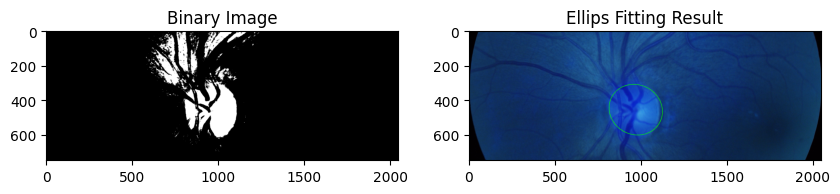

In [90]:
# Menemukan kontur
contours, _ = cv2.findContours(closed_image_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Pastikan ada kontur yang ditemukan
if len(contours) > 0:
    # Ambil kontur terbesar (diasumsikan sebagai optic disc)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Fit ellips ke kontur terbesar
    if len(largest_contour) >= 5:  # Minimum number of points required to fit ellipse
        ellipse = cv2.fitEllipse(largest_contour)
        
        # Buat gambar warna untuk visualisasi
        #color_image = cv2.cvtColor(closed_image, cv2.COLOR_GRAY2BGR)
        
        # Gambar ellips ke gambar warna
        cv2.ellipse(RGB_cropped, ellipse, (0, 255, 0), 2)
        
        # Tampilkan hasil
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title('Binary Image')
        plt.imshow(binary_image, cmap='gray')
        
        plt.subplot(1, 2, 2)
        plt.title('Ellips Fitting Result')
        plt.imshow(RGB_cropped)
        plt.show()
    else:
        print("Kontur tidak cukup poin untuk fitting ellips.")
else:
    print("Tidak ada kontur yang ditemukan.")

SHOW SHOW SHOW

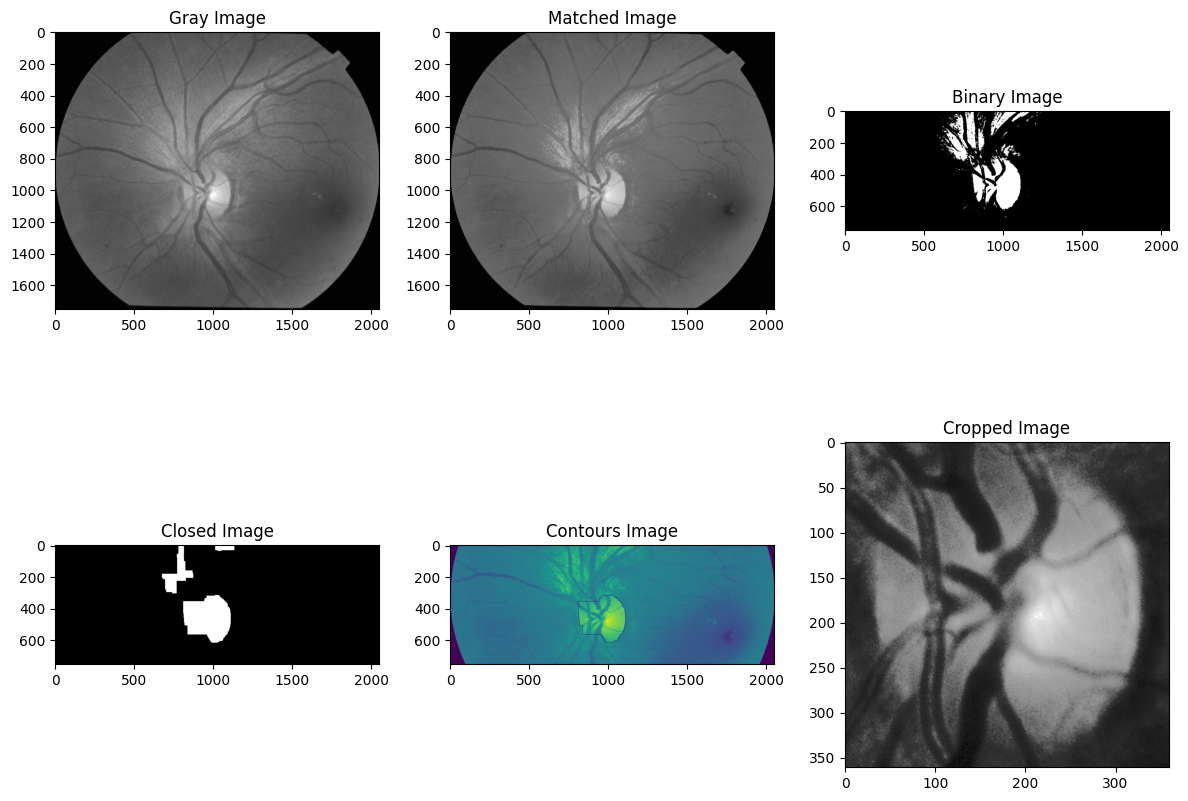

In [91]:
# Create a subplot with 3 rows and 2 columns
plt.figure(figsize=(12, 10))

# Plot the original image
plt.subplot(2, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray Image')

# Plot the gray image
plt.subplot(2, 3, 2)
plt.imshow(matched_image, cmap='gray')
plt.title('Matched Image')

# Plot the binary image
plt.subplot(2, 3, 3)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')

# Plot the closed image
plt.subplot(2, 3, 4)
plt.imshow(closed_image, cmap='gray')
plt.title('Closed Image')

# Add these lines after drawing contours and cropping images

# Plot the contours image
plt.subplot(2, 3, 5)
plt.imshow(contour_image)#cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title('Contours Image')

# Plot the cropped image
plt.subplot(2, 3, 6)
plt.imshow(optic_disc_cropped, cmap='gray')
plt.title('Cropped Image')

plt.tight_layout()
plt.show()